In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# For evaluation
from sklearn.metrics import mean_squared_error

# Import keras components
from tensorflow import keras
from keras import layers, callbacks

2025-04-03 02:33:52.083894: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 02:33:52.101584: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743672832.119108  707464 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743672832.124455  707464 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743672832.145348  707464 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [15]:
# Load training and test datasets from the Kaggle input folder
all_train = pd.read_csv('kbtu-data-science-challenge-2025-entry-task-new/train.csv')
real_test = pd.read_csv('kbtu-data-science-challenge-2025-entry-task-new/test.csv')

# Create binary target for classification: 1 if perfect score, else 0
all_train['perfect'] = (all_train['final_math_score'] == 100).astype(int)

# Show first few rows of training data
all_train.head()

,student_id,gender,age,study_hours,attendance_rate,previous_scores,parental_education,school_type,extracurricular,final_math_score,perfect
0,1001,Male,17,9.1,68.7,70.0,Bachelor’s,Private,3,86.2,0
1,1002,Female,17,10.5,66.6,84.8,Bachelor’s,Public,3,90.6,0
2,1003,Male,17,17.4,58.8,73.8,High School,Private,3,94.1,0
3,1004,Male,17,8.1,80.4,45.0,High School,Public,1,82.9,0
4,1005,Male,18,17.7,73.8,51.1,Master’s,Public,2,98.6,0


In [30]:
# Preprocessor setup

target = 'final_math_score'
ID = 'student_id'
features = ['gender', 'age', 'study_hours', 'attendance_rate', 
            'previous_scores', 'parental_education', 'school_type', 'extracurricular']

num_cols = ['age', 'study_hours', 'attendance_rate', 'previous_scores', 'extracurricular']
cat_cols = ['gender', 'parental_education', 'school_type']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

In [ ]:
train = all_train[all_train[target] < 100]

x = preprocessor.fit_transform(train[features])
y = train[target]

x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.2, random_state=42)

print("Processed training shape:", x_train.shape)

Processed training shape: (2343, 9)


In [27]:
def build_classifier(input_dim):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_dim=input_dim),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_dim_class = train[features].shape[1]
classifier = build_classifier(input_dim_class)
classifier.summary()

/home/qonus/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,689 (10.50 KB)

 Trainable params: 2,689 (10.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def build_regression_model(input_dim):
    model = keras.Sequential([
        # keras.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu', input_dim=input_dim),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='linear')
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
    return model

input_dim_reg = reg_train[features].shape[1]
regressor = build_regression_model(input_dim_reg)
regressor.summary()

/home/qonus/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
early_stop_reg = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_reg = regressor.fit(
    reg_train[features], reg_train[target],
    validation_data=(reg_test[features], reg_test[target]),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop_reg],
    verbose=1
)


ValueError: Invalid dtype: object

In [11]:
val_mse_reg = regressor.evaluate(X_val_reg, y_val_reg, verbose=0)[0]
print("Validation MSE (Regression):", val_mse_reg)

Validation MSE (Regression): 21.40322494506836


In [28]:
early_stop_class = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_class = classifier.fit(
    X_train_class, y_train_class,
    validation_data=(X_val_class, y_val_class),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop_class],
    verbose=1
)

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6814 - loss: 0.5840 - val_accuracy: 0.9062 - val_loss: 0.2614
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8887 - loss: 0.2725 - val_accuracy: 0.9237 - val_loss: 0.1855
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8997 - loss: 0.2323 - val_accuracy: 0.9275 - val_loss: 0.1716
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9042 - loss: 0.2122 - val_accuracy: 0.9275 - val_loss: 0.1703
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9048 - loss: 0.2189 - val_accuracy: 0.9287 - val_loss: 0.1690
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9103 - loss: 0.2015 - val_accuracy: 0.9250 - val_loss: 0.1661
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9094 - loss: 0.2094 - val_accuracy: 0.9250 - val_loss: 0.1663
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9011 - loss: 0.2105 - val_accu

In [29]:
val_loss, val_accuracy = classifier.evaluate(X_val_class, y_val_class, verbose=0)
print("Validation Accuracy:", val_accuracy)

Validation Accuracy: 0.9312499761581421


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix for Perfect Score Classification:
[[ 940 1989]
 [ 559  512]]

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.32      0.42      2929
           1       0.20      0.48      0.29      1071

    accuracy                           0.36      4000
   macro avg       0.42      0.40      0.36      4000
weighted avg       0.51      0.36      0.39      4000

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Integrated Model MSE: 256.4090754069641


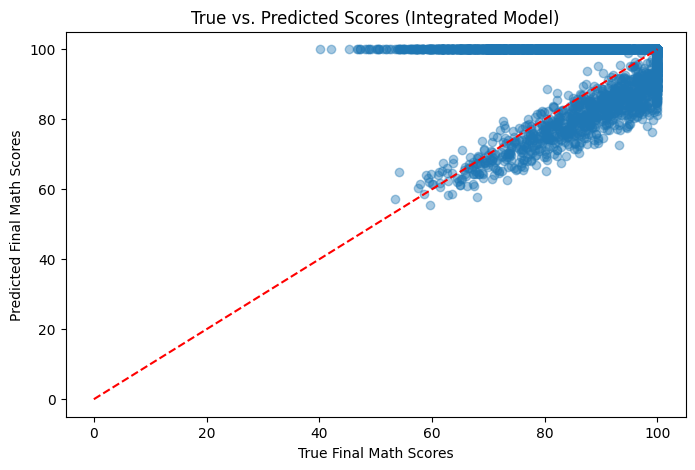

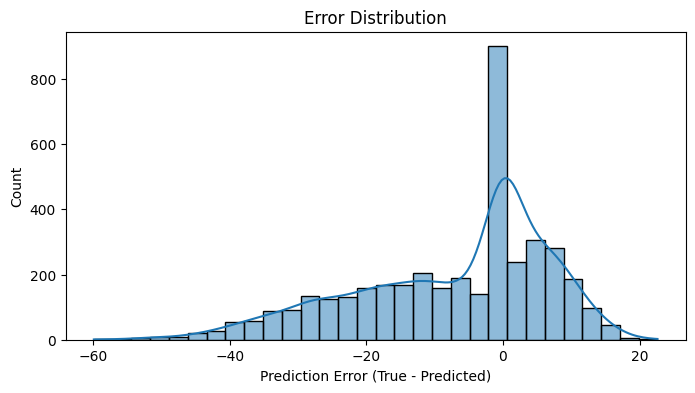

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report

X_eval = train_df[features]
y_eval = train_df['final_math_score']

X_eval_processed = preprocessor.transform(X_eval)

perfect_prob_eval = classifier.predict(X_eval_processed).flatten()

y_pred_class = (perfect_prob_eval >= 0.5).astype(int)
y_true_class = (y_eval == 100).astype(int)

cm = confusion_matrix(y_true_class, y_pred_class)
cr = classification_report(y_true_class, y_pred_class)

print("Confusion Matrix for Perfect Score Classification:")
print(cm)
print("\nClassification Report:")
print(cr)

regression_preds_eval = regressor.predict(X_eval_processed).flatten()

final_predictions_eval = np.where(perfect_prob_eval >= 0.5, 100, regression_preds_eval)

# Ensure predictions are within valid range
final_predictions_eval = np.clip(final_predictions_eval, 0, 100)

# Compute overall Mean Squared Error for the integrated model
integrated_mse = mean_squared_error(y_eval, final_predictions_eval)
print("\nIntegrated Model MSE:", integrated_mse)

# --- Visualization: Compare True vs. Predicted Scores ---
plt.figure(figsize=(8, 5))
plt.scatter(y_eval, final_predictions_eval, alpha=0.4)
plt.xlabel("True Final Math Scores")
plt.ylabel("Predicted Final Math Scores")
plt.title("True vs. Predicted Scores (Integrated Model)")
plt.plot([0, 100], [0, 100], color='red', linestyle='--')  # reference line
plt.show()

# Optionally, inspect distribution of errors
errors = y_eval - final_predictions_eval
plt.figure(figsize=(8, 4))
sns.histplot(errors, bins=30, kde=True)
plt.xlabel("Prediction Error (True - Predicted)")
plt.title("Error Distribution")
plt.show()

In [14]:
# Evaluate on the validation set
val_mse = regressor.evaluate(X_val, y_val, verbose=0)[0]
print("Validation MSE:", val_mse)

# Plot training and validation loss over epochs
plt.figure(figsize=(8,4))
plt.plot(regressor.history['loss'], label='Train Loss')
plt.plot(regressor.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

Validation MSE: 54.073429107666016


TypeError: 'History' object is not subscriptable

<Figure size 800x400 with 0 Axes>

In [ ]:
# Predict on test data
predictions = model.predict(X_test_processed).flatten()

# Optionally, clip predictions to the valid range [0, 100]
predictions = np.clip(predictions, 0, 100)

# Create submission DataFrame in the required format
submission = pd.DataFrame({
    'student_id': test_df['student_id'],
    'predicted_math_score': predictions
})

submission.head()

# Save to CSV file
submission.to_csv('submission.csv', index=False)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
